# Prepare input data for training a supervised learning model

*Authors: Adrian Di Paolo, Chung-Xiang Hong, Jonas Viehweger* 

This notebook shows the steps towards preparing data for training a supervised machine learning model. We will train the model based on the [pan-European High Resolution Vegetation Phenology and Productiviy (HR-VPP)](https://collections.sentinel-hub.com/vegetation-phenology-and-productivity-parameters-season-1/) data, which is derived from ESA’s Sentinel-2 as part of the Copernicus Land Monitoring Service (CLMS). The 13 parameters that describe specific stages of the seasonal vegetation growth cycle will be used as input features to fit a model.

As for the ground truth, we will use the [EuroCrops](https://github.com/maja601/EuroCrops#vectordata_zenodo) data, which is a dataset combining all publicly available self-declared crop reporting datasets from countries of the European Union.

In this example notebook, the expected outcome is a binary classifier that identifies grassland and non-grassland areas in the Netherlands. We will start by preparing a small dataset to train models with different algorithms, so we can have an overview on the performance of the models that is essential in the following model selection process.

Preparing the data at small scale for training a model can be simple and straightforward with the following three steps:
1. [Define training and validation area](#1-define-training-and-validation-area)
2. [Obtain features and labels](#2-obtain-features-and-labels)
3. [Reshape data for model training](#3-reshape-data-for-model-training)

**Note about Environment:** There is an `environment.yml` included, with which all the necessary libraries can be installed into a conda environment. They can be installed using  

In [1]:
# Necessary imports

# Jupyter notebook related
%matplotlib inline

# Built-in modules
import os
from pathlib import Path

# Data handling
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio.features import rasterize
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import mypy
from typing import Union

# Visualisation
import folium
import matplotlib.pyplot as plt

# Data access
from hda import Client, Configuration

## 1. Define training and validation area

To train a machine learning model, we need to define a training dataset and a validation dataset. The training data set is a set of example data which is used to fit the parameters (e.g., weights) during the learning process. Then, the trained model needs to be evaluated using examples from the held-out dataset, which is the validation dataset that is independent of the training dataset and is not used in the training process.

In our case, we will randomly select a training area and a validation area in the Netherlands to obtain examples for the training and the evaluation process. First let's take a look at these two areas.

In [2]:
# define bounding box
bounds_poly = gpd.read_file("./data/bounding_boxes.geojson")
validation_gdf = bounds_poly[-1:]
train_gdf = bounds_poly[:-1]

In [3]:
def gdf_bbox(gdf: gpd.GeoDataFrame) -> list:
    """This returns the bounding box 
    of all geometries in a geodataframe"""
    return list(gdf.total_bounds)

In [4]:
# These bounding boxes are needed to later query the EuroCrops dataset
total_bbox = gdf_bbox(bounds_poly.to_crs(4326))
validation_bbox = gdf_bbox(validation_gdf.to_crs(4326))
train_bbox = gdf_bbox(train_gdf.to_crs(4326))

In [5]:
_map = folium.Map(location=(53.104538500000004, 7.014084), zoom_start=8) 
folium.GeoJson(data=validation_gdf['geometry'], style_function=lambda x:{"color": "red"}).add_to(_map)
folium.GeoJson(data=train_gdf['geometry'], style_function=lambda x:{"color": "blue"}).add_to(_map)
_map

### Explore the ground truth dataset

Since we are going to train a binary classification model to identify if an area is grassland or not in the Netherlands, it is important to investigate the distribution of crop types in the country.  

Here we display the distribution of the top 10 categories reported in the Netherlands. We can see that grassland is the most dominant category in the data, which is a critical point we should pay attention to when sampling data for training at a national scale.

**Note** that [EuroCrops Netherlands](https://zenodo.org/record/7476474/files/NL_2020.zip?download=1) data needs to be downloaded and saved in the same folder where this notebook is located.

This is also quite a big dataset, so loading it entirely may take a while.

In [6]:
# load full dataset to GeoDataFrame
EC_NETHERLANDS_PATH = "./data/NL_2020_EC21.shp"
netherlands_gt = gpd.read_file(EC_NETHERLANDS_PATH)

In [7]:
netherlands_gt.head()

,objectid,gewascateg,gewas,gewascode,length,area,EC_trans_n,EC_hcat_n,EC_hcat_c,geometry
0,1526148,Grasland,"Grasland, blijvend",265,909.550630,36979.234287,Grassland permanent,pasture_meadow_grassland_grass,3302000000,"POLYGON ((5.84121 53.03229, 5.84116 53.03232, ..."
1,1526149,Bouwland,"Maïs, snij-",259,776.710589,29993.104736,maize cut,green_silo_maize,3301090400,"POLYGON ((5.86440 51.59805, 5.86432 51.59804, ..."
2,1526150,Natuurterrein,Natuurterreinen (incl. heide),335,422.901620,6995.393204,Natural areas (incl. heath),not_known_and_other,3399000000,"POLYGON ((6.20936 51.36140, 6.20953 51.36136, ..."
3,1526151,Natuurterrein,Natuurterreinen (incl. heide),335,681.398010,5878.385941,Natural areas (incl. heath),not_known_and_other,3399000000,"POLYGON ((5.74748 51.47328, 5.74732 51.47332, ..."
4,1526152,Bouwland,"Aardbeien open grond, vermeerdering",2700,33.285656,21.897334,Strawberries open ground propagation,strawberries,3301130000,"POLYGON ((6.86887 52.23887, 6.86864 52.23888, ..."


In [8]:
# sort catagories by value counts
categories = netherlands_gt.EC_hcat_n.value_counts(sort=True)

# create a subset for the top 10 catagories
categories_subset = categories[0:10]

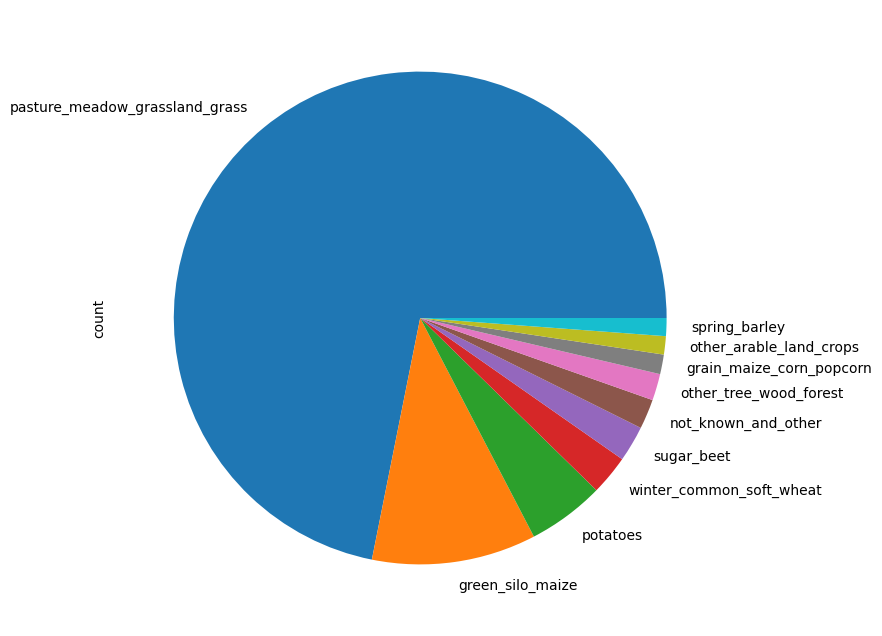

In [9]:
# create pie chart
categories_subset.plot.pie(figsize=(15,8));

Next, let's have a closer look at the data in the training area and the validation area. We can see the distribution of crop types is much more balanced in both the training area and validation area.

In [10]:
# load training dataset
train_gt = gpd.read_file(EC_NETHERLANDS_PATH, bbox=train_bbox)

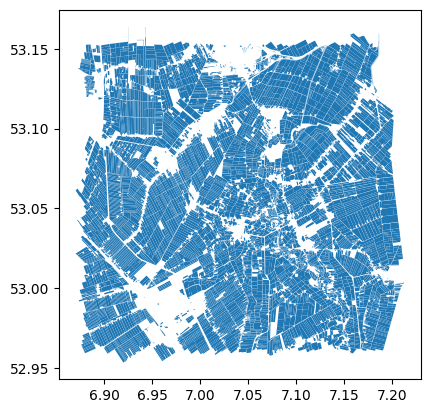

In [11]:
# plot all geometries in the training area
train_gt.plot();

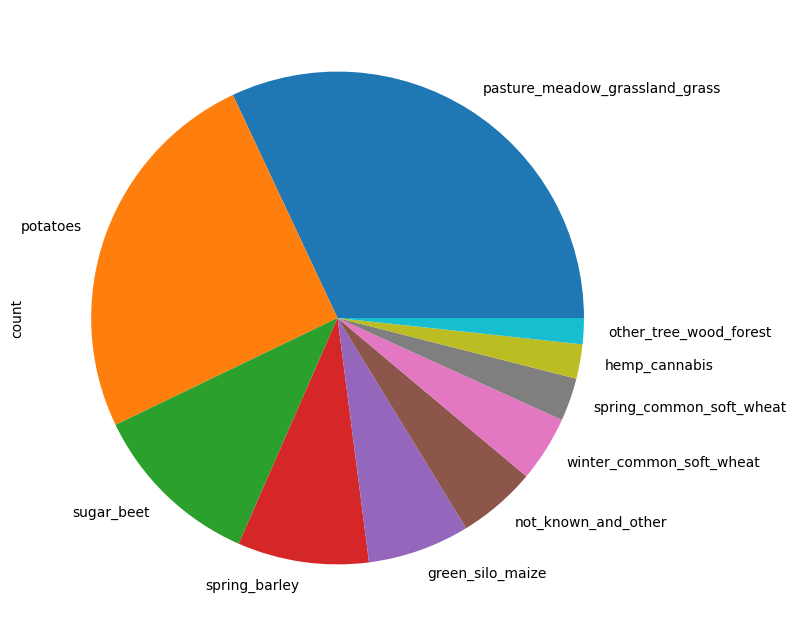

In [12]:
# create pie chart
train_gt.EC_hcat_n.value_counts(sort=True)[:10].plot.pie(figsize=(15,8));

In [13]:
# load validation dataset
validation_gt = gpd.read_file(EC_NETHERLANDS_PATH, bbox=validation_bbox)

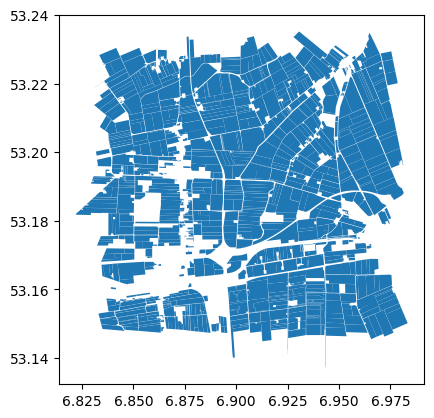

In [14]:
validation_gt.plot();

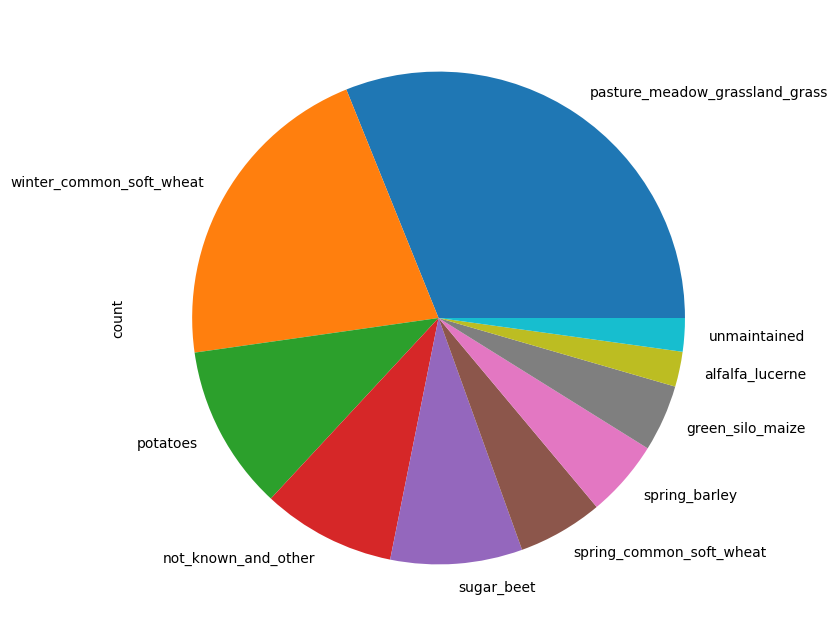

In [15]:
validation_gt.EC_hcat_n.value_counts(sort=True)[:10].plot.pie(figsize=(15,8));

### Bias

Training and validating a model with samples in small areas will introduce a bias. The bias comes from two aspects:
* The imbalanced samples of grassland and non-grassland
* The spatial correlation between samples

This will be addressed later when preparing data at a large scale to train a model general enough for the whole country.

## 2. Obtain HR-VPP data and labels

In total we will show two possibilities to get HR-VPP data. The first is by using the HDA API which is available on WEkEO. This API has a few limitations which necessitate a bit more post-processing of the data. In a later notebook we will show how to access the data using the Sentinelhub API which is more capable in its processing.

### Downloading Data

First the data is downloaded from WEkEO using the HDA python library. A getting started tutorial for the API is available [here](https://help.wekeo.eu/en/articles/6751608-what-is-the-hda-api-python-client-and-how-to-use-it). 

For the download we specify a helper function which subsets the data query to only a single tile. This is done to reduce the amount of data that will be downloaded, since a lot of tiles are overlapping the study area. The HDA API will always download entire tiles even if you are only interested in small parts of the tile.

In [16]:
def hda_tile_download(client: Client, query: dict, tile: str, folder: Union[str, os.PathLike]) -> None:
    # The following line runs the query
    matches = client.search(query)
    # This subsets the search results, so only results in the specified tile are included
    matches_subset = [match for match in matches.results if tile in match["filename"]]
    matches.results = matches_subset
    matches.download(folder)

In the query we specify which dataset we want to download, for which timeframe and for which area.

In [17]:
from credentials import WEKEO_USER, WEKEO_PASSWORD
conf = Configuration(user = WEKEO_USER, password = WEKEO_PASSWORD)
c = Client(config = conf, progress=False)

query = {
    "datasetId": "EO:EEA:DAT:CLMS_HRVPP_VPP",
    "boundingBoxValues": [
        {
        "name": "bbox",
        "bbox": total_bbox }
    ],
    "dateRangeSelectValues": [
        {
        "name": "temporal_interval",
        "start": "2020-01-01T00:00:00.000Z",
        "end": "2020-01-01T00:00:00.000Z"
        }
    ],
    "stringChoiceValues": [
        {
        "name": "productGroupId",
        "value": "s1"
        },
        {
        "name": "productVersion",
        "value": "V101"
        }
    ]
}

hda_tile_download(c, query, tile="T32ULD", folder="./hda")

In [18]:
file_list = list(Path("./hda/").glob("*.tif"))
file_list.sort()
file_list

[PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_AMPL.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_EOSD.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_EOSV.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_LENGTH.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_LSLOPE.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_MAXD.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_MAXV.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_MINV.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_QFLAG.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_RSLOPE.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_SOSD.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_SOSV.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_SPROD.tif'),
 PosixPath('hda/VPP_2020_S2_T32ULD-010m_V101_s1_TPROD.tif')]

The HDA API downloads the different bands in separate files. So the next step is to read in the data for our training and validation areas and stack them together.

In [19]:
def stack_hrvpp(file_list: list, gdf: gpd.GeoDataFrame) -> np.ndarray:
    arrays = []
    bounds = gdf_bbox(gdf)
    for file in file_list:
        with rio.open(file) as src:
            assert gdf.crs == src.crs
            transform = src.transform
            window = from_bounds(*bounds, transform).round_offsets().round_lengths()
            arrays.append(src.read(1, window=window))
    bounds = rio.windows.bounds(window, transform)
    new_transform = rio.transform.from_bounds(*bounds, window.width, window.height)
    return (np.stack(arrays, axis=-1), new_transform)

In [20]:
train_data, train_transform = stack_hrvpp(file_list, train_gdf)
validation_data, validation_transform = stack_hrvpp(file_list, validation_gdf)

In [21]:
train_data.shape

(2045, 2118, 14)

In [22]:
validation_data.shape

(852, 877, 14)

We now have two arrays, one for the training area and one for the validation area, which is smaller than the one for the training area. But both arrays now have all 14 bands as their third dimension.

### Get labels

We have the HR-VPP data of both training and validation areas now. Next, we want to get the labels for these two areas as the ground truth to perform a supervised training.

To do this, we have to convert the vector data to raster data. This is done with the `get_labels` function which sets up the data for the `rasterio` function `rasterize()`.

In [23]:
def get_crs(tiff_path):
    with rio.open(tiff_path) as src:
        crs = src.crs
    return crs

In [33]:
crs = get_crs(file_list[0])

In [34]:
# A helper function to get labels
def get_labels(ec_gt: gpd.GeoDataFrame, 
               geotransform, 
               out_shape: Union[tuple, list], 
               raster_crs: rio.crs.CRS) -> np.ndarray:
    ec_gt["label"] = ec_gt.EC_hcat_c.astype(float)
    geo_iter = list(ec_gt.to_crs(32632)[["geometry", "label"]].itertuples(index=False, name=None))
    rasterized = rasterize(geo_iter, transform=geotransform, out_shape=out_shape, fill=-1)
    return rasterized

In [35]:
train_labels = get_labels(train_gt, train_transform, train_data.shape[0:2], crs)
validation_labels = get_labels(validation_gt, validation_transform, validation_data.shape[0:2], crs)

## 3. Reshape data for model training

At this point we have all the data we need to train a supervised machine learning model. The last step is to reshape the data so that it can be fed into the model. In general, we simply flatten the arrays to go from 3 dimensional data to 2 dimensional data, where the first dimension are the pixels and the second dimension the values of the bands.

In [36]:
def get_model_input(features: np.ndarray, labels: np.ndarray) -> tuple:
    x = np.reshape(features, (-1, features.shape[2]))
    y = labels.flatten()
    x_clean = x[y!=-1,:]
    y_clean = y[y!=-1]
    return x_clean, y_clean

In [37]:
x_data, y_data = get_model_input(train_data, train_labels)

In [38]:
x_validation, y_validation = get_model_input(validation_data, validation_labels)

In [39]:
x_data.shape

(3064183, 14)

In [40]:
y_data.shape

(3064183,)

In [41]:
datasets = {
    'x_validation': x_validation, 
    'y_validation': y_validation,
    'x_data': x_data,
    'y_data': y_data
}
Path("./dataset").mkdir(exist_ok=True)
for name, dataset in datasets.items():
    np.save(Path("dataset/", f"{name}.npy"), dataset)

## Conclusion

When preparing the input data for a supervised learning task, there are a few important points which can be the takeaways from this notebook:  
1. Ground truth data is critical for a supervised learning task. It determines how well a model can learn from your data and the reliability of the validation result.
2. It is important to have two separate dataset. One for training and the other for validation. Always make sure that the validation dataset is held-out in the training process.
3. Training with a limited amount of samples can lead to bias. The bias can be alleviated if there are sufficient amounts of samples.  